# Projet Python data scientist 2A

## Classification de bières et rule mining autour d'un trajet de découverte des différentes variétés de bières

## description du projet 

### Situation
- Un amateur de bières souhaite qu'on lui propose un panel de bières à découvrir et qui pourraient lui plaire.
- On pourra éventuellement ajouter différentes contraintes sur cette sélection : budget, pays de provenance... mais ces critères ne rentreront a priori pas dans les clusters (on pourra proposer 2 bières similaires d'après notre algorithme mais aux prix très différents et venant chacune de régions très différentes). 

### Méthode
- On dispose de trois tables de données que l'on va analyser afin d'en vérifier la cohérence.
- On s'attend à ce qu'elle soit plutôt prorpre puisque cette base de données a été utilisée dans des projets kaggle.
- On va réaliser des clusters de bières selon différents critères arbitraire : degré alcoolique, aspect, odeur, goût, feeling. Sans aucune de ces informations, on suprimera la bière de notre base de données (cela signifiera qu'elle n'est pas assez connue pour disposer des informations 'basiques')
- On va tenter d'enrichir la base de données par scrapping du site 'Beer wolf'
- On va ensuite proposer à l'amateur de bières de noter un panel représentatif des bières de notre dataset, et ces notes seront ensuite insérées dans l'algorithme qui lui sortira de nouvelles bières qui correspondent à ses préférences.

In [66]:
# Importation des modules nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

!pip install kaggle
!kaggle config set -n path -v{/content}
api_token = {"username":"simonmariani","key":"7be8038da302e3aa4db13b8859f48ac7"}
import json
import zipfile
import os
with open('C:/Users/sim13/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c beers-breweries-and-beer-reviews
os.chdir('https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

# Nettoyage des données

In [67]:
# Importation des données
beers = pd.read_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\archive\beers.csv') # Les bières
breweries = pd.read_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\archive\breweries.csv') # Les brasseries
reviews = pd.read_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\archive\reviews.csv') # Les notes des bières

## Première analyse descriptive des données : table 'beers'

In [68]:
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [69]:
print(len(beers.name.unique()))
print(len(beers.id.unique()))
beers.describe()

298567
358873


,id,brewery_id,abv
count,358873.000000,358873.000000,320076.000000
mean,189241.027199,24597.365051,6.528504
std,107675.746916,16442.976904,2.085403
min,3.000000,1.000000,0.010000
25%,96422.000000,7318.000000,5.000000
50%,189909.000000,28383.000000,6.000000
75%,282546.000000,37452.000000,7.500000
max,374406.000000,54144.000000,100.000000


### Remarques générales sur la table 'beers'
- On a une grande quantité de données, ce qui devrait faciliter la phase de nettoyage de celles-ci
- La colonne 'abv' correspond au pourcentage alcoolique des bières. La valeur max à 100 est donc impossible et cela onne un premier axe de nettoyage des données. La moyene est à 6.5 ce qui n'est pas aberrant. Les valeurs à exclure doivent donc être limitées.
- On a plus d'id distincts que de noms de bières. Soit un deuxième axe de nettoyage à prévoir

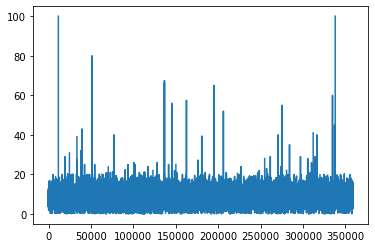

            id         name  brewery_id state country               style  \
136634  104620  Snake Venom       30178   GB6      GB  British Barleywine   

                  availability   abv  \
136634   Limited (brewed once)  67.5   

                                                    notes retired  
136634  Snake Venom is the world’s strongest beer as o...       t  


,id,name,brewery_id,state,country,style,availability,abv,notes,retired
11583,368014,Earache: World's Shortest Album,8396,GB2,GB,Winter Warmer,Year-round,100.0,No notes at this time.,f
51390,311921,Dark Reckoning,47203,CA,US,American Porter,Limited (brewed once),80.0,No notes at this time.,f
313867,368012,Radiohead - OK Computer,8396,GB2,GB,Smoke Beer,Year-round,100.0,No notes at this time.,f
338025,365307,water,25916,AL,US,German Altbier,Rotating,100.0,No notes at this time.,f


In [70]:
fig = beers.abv.plot()
plt.show()
print(beers[beers.name == 'Snake Venom'])
beers[beers['abv'] > 67.5] #La bière la plus forte du monde est la Snake Venom à 67.5 %. 

Le graphique sur les pourcentages alcooliques 'abv' montre que les bières avec valeur aberrantes (abv > 67.5, la bière la plus forte du monde, la snake venom, émarge à 67.5 %) sont au nombre 4. La première, la 'Dark Reconing - Amrican Porter', est une erreur. Sur le site de la brasserie, on voit que l'abv de cette bière est en fait de 5.9 %. Nous allons corriger cette valeur pour la suite.


Les trois autres bières qui émargent à 100 % sont des anomalies volontaires, des blagues qui correspondent à de l'eau, et deux album de Rock. On les retire de la table pour la suite.

In [71]:
[beers[beers.abv == 100.0].index[i] for i in range(len(beers[beers.abv == 100.0]))]

[11583, 313867, 338025]

In [72]:
beers.reset_index()
beers.set_index('id')
# On supprime les bières qu affichent un abv de 100
beers = beers.drop([beers[beers.abv == 100.0].index[i] for i in range(len(beers[beers.abv == 100.0]))])

In [73]:
beers.loc[beers['abv'] == 80.0, 'abv'] = 5.9
beers[beers.name == 'Dark Reckoning']

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
51390,311921,Dark Reckoning,47203,CA,US,American Porter,Limited (brewed once),5.9,No notes at this time.,f
316366,296242,Dark Reckoning,47203,CA,US,Baltic Porter,Limited (brewed once),8.0,No notes at this time.,t


On va à présent travailler sur les valeurs manquantes 

In [74]:
# On supprime les doublons
beers.drop_duplicates(keep = False)
beers.describe()

,id,brewery_id,abv
count,358870.000000,358870.000000,320073.000000
mean,189239.540282,24597.451668,6.527397
std,107674.968777,16443.001002,2.061599
min,3.000000,1.000000,0.010000
25%,96421.250000,7318.000000,5.000000
50%,189907.500000,28383.000000,6.000000
75%,282543.750000,37452.000000,7.500000
max,374406.000000,54144.000000,67.500000


In [75]:
beers.isnull().sum()
# Seules quelques colonnes possèdent des valeurs manquantes, on va tenter d'en savoir plus

id                  0
name                0
brewery_id          0
state           60726
country           154
style               1
availability        0
abv             38797
notes              46
retired             0
dtype: int64

Dans un premier temps, on cherche à nettoyer notre dataset afin de réaliser une modélisation sur le type d'un amateur de bière à partir de ses préférences en termes de goût. On ne va ainsi pas s'attarder sur les valeurs manquantes de 'state' et 'country' car elles ne caractérisent pas directement une bière par rapport de manière qualitative.

On va en recanche essayer d'y voir plus clair quant aux valeurs manquantes du pourcentage alcoolique 'abv'.

In [76]:
# Quelle sorte de valeurs manquantes
print(beers[beers.abv.isnull()].abv.unique()) # que des nan

# On stocke les id et nom des bières valeurs manquantes dans un dataframe 
beers_without_abv = beers[beers.abv.isnull()]
beers_without_abv = beers_without_abv.drop(['state', 'country', 'notes', 'abv', 'retired', 'availability'], axis = 'columns')
beers_without_abv

[nan]


,id,name,brewery_id,style
21,15645,Cerveza India,846,American Adjunct Lager
32,55175,Samuel Adams New World Lager,35,American Amber / Red Lager
38,174277,Trip In The Woods: Madeira Aged Ovila,140,Belgian Quadrupel (Quad)
51,144221,Java-Lantern Porter,35374,Pumpkin Beer
68,57062,Oxidizer,1550,American Imperial IPA
...,...,...,...,...
358775,140147,Göller Urstoff,5828,German Kellerbier / Zwickelbier
358827,175142,Blanche D'Haberville,40655,Belgian Witbier
358858,271967,Turbid #2,32908,American IPA
358866,307651,Drunkard's Cloak,32722,Belgian Saison


Il n'y a que 0.1 % de valeurs manquantes, ce qui ne pose pour l'instant pas de problème. Avant de décider d'une éventuelle imputation voire suppression, nous allons donc voir si ces valeurs manquent dans les deux autres tables. On utilisera pour ce faire la table 'beers_without_abv'. Notre but est de conserver le maximum de bières différentes, ainsi si certaines bières sans leur pourcentage alcoolique présentent quand même des avis dans la table 'reviews', on les conservera dans la base de données.

## Première analyse de la base de données : 'breweries'

In [77]:
print(breweries.isnull().sum())
print(beers.name.count()/breweries.name.count())
breweries.head()

id             0
name           0
city          58
state      11271
country        6
notes         85
types          0
dtype: int64
7.127932150872942


,id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
4,35328,Brighton Beer Dispensary (DUPLICATE),Brighton,GB2,GB,Duplicate of https://www.beeradvocate.com/beer...,"Bar, Eatery"


En moyenne, une brasserie produit 7 bières. On va s'assurer qu'il n'y a pas de doublons.

Les valeurs manquantes se situent seulement dans 'city', 'state', 'country' et 'notes', des variables string qui ne ovnt pas, à première vue, venir nourrir notre modélisation. 

In [78]:
breweries.drop_duplicates(keep = False)
breweries.describe()

# Il n'y a pas de doublons

,id
count,50347.000000
mean,27870.513874
std,15270.535930
min,1.000000
25%,15487.500000
50%,28313.000000
75%,40922.500000
max,54156.000000


## Première analyse de la base de données : table 'reviews'

In [79]:
reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [80]:
reviews.describe()

,beer_id,look,smell,taste,feel,overall,score
count,9.073128e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,9.073128e+06
mean,7.730655e+04,3.952155e+00,3.887863e+00,3.920704e+00,3.884350e+00,3.916280e+00,3.889815e+00
std,7.929345e+04,5.517191e-01,6.115910e-01,6.333365e-01,5.999279e-01,6.054554e-01,6.127417e-01
min,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.155400e+04,3.750000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.570000e+00
50%,5.654500e+04,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,1.076670e+05,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,3.731280e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


### Remarques générales

C'est la table la plus conséquente et de loin avec presque 10 millions de lignes. Elle correspond aux avis de millions d'internautes sur les bières de la table 'beers'. Chaque internaute a noté une ou plusieurs bières selon 4 critères : 'look', 'smell', 'taste' et 'feel'. On compte réaliser la modélisation à partir de ces critères et allons donc travailler dessus.

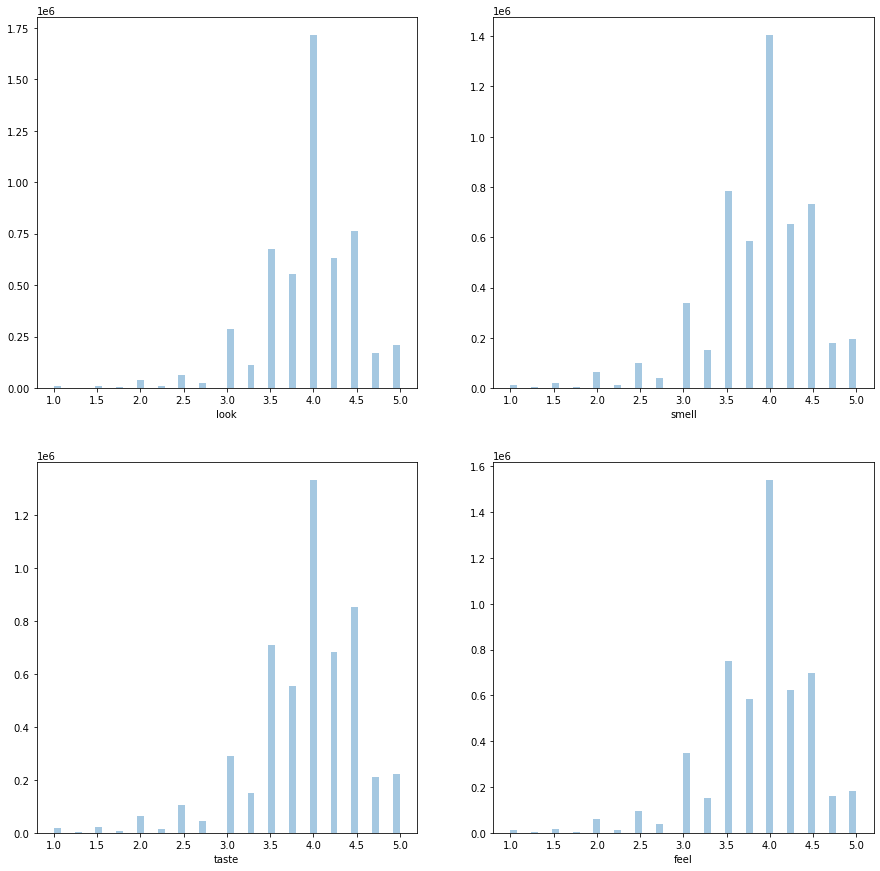

In [81]:
figure = plt.figure(1, figsize = (15, 15))
plt.subplot(221)
sns.distplot(reviews.look, kde = False)
plt.subplot(222)
sns.distplot(reviews.smell, kde = False)
plt.subplot(223)
sns.distplot(reviews.taste, kde = False)
plt.subplot(224)
sns.distplot(reviews.feel, kde = False)
plt.show()

### Répartition des notes

- On a pas de valeurs aberrantes (que des notes entre 1 et 5)
- Les notes sont précises au quart de point (0.25) près. On remarque que la note prédominante est le 4/5. On va tenter de voir s'il existe des corrélations entre ces notes.

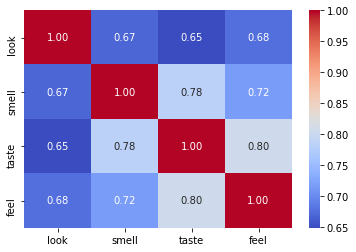

In [82]:
# Matrice de corrélation pour les 4 critères 
sns.heatmap(reviews[['look', 'smell', 'taste', 'feel']].corr(), cmap='coolwarm', annot=True, fmt=".2f")

De manière assez surprenante, si les critères semblent relativement liés enter eux, la corrélation est à exclure. Cela est très satisfaisant car il va nous permettre de réaliser de réaliser une véritable classification des bières : les meilleures pour lesquelles tous les critères sont hauts, celles à l'arome prédominant, etc.

In [83]:
# Valeurs manquantes
reviews.isnull().sum()

beer_id           0
username       3815
date              0
text              0
look        3790018
smell       3790018
taste       3790018
feel        3790018
overall     3790018
score             0
dtype: int64

### Valeurs manquantes : 

- Les valeurs manquantes sur les 'username' ne sont pas très importantes.
- On a plus de 3 millions de valeurs manquantes pour les critères qui nous intéressent. Ce qui nous laisse 7 millions de lignes pour entraîner l'algorithme. Cela semble suffisant mais on va quand même s'assurer que ces 3 millions d'avis ne concernent qu'un nombre limité de bières très peu connues. 

NB : On va en parallèle tenter de trouver d'autres notations de bières et de les insérer via scrapping dans cette table.

On va vérifier que les bières dont il manquait le pourcentage alcoolique dans la table 'beers' font également partie de celles qui n'ont pas d'avis dans la table 'reviews'. 

In [84]:
# Les notes des bières
print(reviews[reviews.beer_id.isin(beers_without_abv.id)].look.unique())
print(reviews[reviews.beer_id.isin(beers_without_abv.id)].smell.unique())
print(reviews[reviews.beer_id.isin(beers_without_abv.id)].taste.unique())
print(reviews[reviews.beer_id.isin(beers_without_abv.id)].feel.unique())

[4.   3.25 3.75 2.75 3.    nan 4.5  3.5  5.   4.75 2.5  4.25 2.25 2.
 1.5  1.25 1.75 1.  ]
[4.   4.25 3.75 2.75  nan 4.5  5.   3.   3.5  2.5  2.   3.25 4.75 2.25
 1.5  1.   1.75 1.25]
[4.   3.5  3.    nan 4.75 4.5  3.75 2.75 4.25 2.5  3.25 5.   2.25 2.
 1.   1.5  1.75 1.25]
[4.   3.5  3.25  nan 4.5  3.75 4.25 2.5  3.   5.   4.75 2.75 1.5  2.25
 2.   1.   1.75 1.25]


Clairement, on voit que ce n'est pas le cas. Notre but est toujours de garder le maximum de bières possible dans la table 'reviews' afin de pouvoir proposer à l'amateur de bières une diversité de bières la plus grande possible. On préfèrera donc garder une bière qui n'a pas d'abv dans la table 'beers' mais qui est notée dans la table 'reviews', quitte à scrapper cet abv plus tard. En revance, on va supprimer de la table les bières qui n'ont ni abv ni note dans review. 

In [85]:
# identification des bières qui n'ont ni 'abv' ni avis dans 'reviews'
without_look = reviews[reviews.beer_id.isin(beers_without_abv.id)].look.isnull().index
without_taste = reviews[reviews.beer_id.isin(beers_without_abv.id)].taste.isnull().index
without_smell = reviews[reviews.beer_id.isin(beers_without_abv.id)].smell.isnull().index
without_feel = reviews[reviews.beer_id.isin(beers_without_abv.id)].feel.isnull().index

In [86]:
# On s'assure ci_dessous que les indices sont les mêmes dans les 4 listes
assert without_look.all() == without_taste.all() == without_smell.all() == without_feel.all()

# On supprime des 3 tables les bières qui n'ont ni avis ni abv : on ne pourra rien en tirer
# Les 4 listes without sont équivalentes et on en utilise qu'une
reviews = reviews.drop(reviews[reviews.index.isin(without_look)].index)
beers = beers.drop(beers[beers.index.isin(without_look)].index)
breweries = breweries.drop(breweries[breweries.index.isin(without_look)].index)

## Création du dataframe qui servira à entraîner l'algorithme avant éventuel enrichissement grâce au scrapping

On crée par jointure sur les id_beer un dataframe qui contient :
- name, style abv de beers
- look, smell, taste, feel de reviews
- name de breweries

On va opérer à un outer join lors de l'insertion des données de reviews car on pourra ne pas utiliser toutes les colonnes pour toutes les modélisations (on veut caractériser le maximum de bières avec le maximum de clusterings différents).

On entraînera l'algorithme de ML avec les données numériques abv, look, smell, taste, feel et on sortira les informations des bières name, style et nom de la brasserie.

In [90]:
df_ml = pd.merge(beers[['name', 'style', 'abv', 'id', 'brewery_id']], breweries[['name', 'id']], left_on = ['brewery_id'], right_on = ['id'])
# On renommme les colonnes pour éviter la confusion et on supprime les doublons de colonnes
df_ml = df_ml.drop(['id_y'], axis = 'columns')
df_ml = df_ml.rename(columns={'name_x': 'beer_name', 'name_y': 'brewery_name', 'id_x' : 'id'})

# On merge avec reviews
df_ml = pd.merge(df_ml, reviews[['look', 'smell', 'taste', 'feel', 'beer_id']], left_on = ['id'], right_on = ['beer_id'])
# On renomme les colonnes et on supprime les doublons
df_ml = df_ml.reset_index()
df_ml = df_ml.set_index('id')
df_ml = df_ml.drop(['index', 'beer_id'], axis = 'columns')
df_ml = df_ml.rename(columns = {'style' : 'beer_style'})
df_ml

,beer_name,beer_style,abv,brewery_id,brewery_name,look,smell,taste,feel
id,,,,,,,,,
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,3.5,4.0,3.5
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.5,3.0,3.5,4.0
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,3.5,4.0,3.5
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,4.0,4.0,4.5
8749,Pleasanton Pale Ale,American Pale Ale (APA),5.3,2199,Main Street Brewery,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
167034,Vals Paterke,Belgian Strong Pale Ale,8.3,40028,Brouwerij 't Drankorgel,NaN,NaN,NaN,NaN
214214,Crus - Sacra Birra,Belgian Dubbel,7.0,44211,Birrificio Artigianale Opera,NaN,NaN,NaN,NaN
200378,Caudillo India Pale Ale,English India Pale Ale (IPA),8.3,43193,Cerveza Caudillo,NaN,NaN,NaN,NaN


In [92]:
print(df_ml.isnull().sum())
df_ml.describe()

beer_name             0
beer_style            0
abv                   0
brewery_id            0
brewery_name          0
look            3535815
smell           3535815
taste           3535815
feel            3535815
dtype: int64


,abv,brewery_id,look,smell,taste,feel
count,8.493610e+06,8.493610e+06,4.957795e+06,4.957795e+06,4.957795e+06,4.957795e+06
mean,7.329427e+00,1.030895e+04,3.955076e+00,3.891066e+00,3.924029e+00,3.887565e+00
std,2.477877e+00,1.344701e+04,5.499752e-01,6.097434e-01,6.312379e-01,5.980387e-01
min,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.500000e+00,1.920000e+02,3.750000e+00,3.500000e+00,3.500000e+00,3.500000e+00
50%,6.800000e+00,1.146000e+03,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,8.700000e+00,2.215000e+04,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,6.750000e+01,5.408000e+04,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


## Corrélation des facteurs

On a déjà pu observer une première corrélation enter les quatre facteurs de 'reviews'. On va maintenant intégrer l'abv et analyser plus en détail les features.

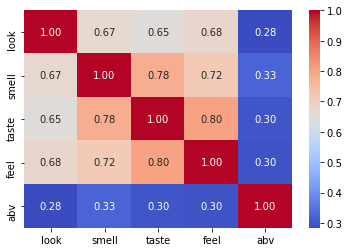

In [93]:
# Matrice de corrélation pour les 4 critères 
sns.heatmap(df_ml[['look', 'smell', 'taste', 'feel', 'abv']].corr(), cmap='coolwarm', annot=True, fmt=".2f")